![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Calculate VPD from air temperature and relative humidity
</b>
</span>

---
**Notebook version**: `3` (24 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Description**

- Air temperature (TA) and relative humidity (RH) are two widely available measurements
- VPD can be calculated from TA and RH
- In this example, gap-filled TA is used in combination with RH (not gap-filled) to calculate VPD 
- `QuickFillRFTS` is used for quick gap-filling of the calculated VPD. It uses the input features in combination with timestamp info.

</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.times.times import insert_timestamp  # Used to insert TIMESTAMP_END
from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # Used for plotting
from diive.pkgs.gapfilling.randomforest_ts import QuickFillRFTS  # Used for gap-filling
from diive.pkgs.createvar.vpd import calc_vpd_from_ta_rh  # Used to calculate VPD

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

diive version: v0.65.0


</br>

# **Docstring**

In [2]:
help(calc_vpd_from_ta_rh)

Help on function calc_vpd_from_ta_rh in module diive.pkgs.createvar.vpd:

calc_vpd_from_ta_rh(df: pandas.core.frame.DataFrame, rh_col: str, ta_col: str) -> pandas.core.series.Series
    Calculate VPD from air temperature and relative humidity
    
    Args:
        df: Data
        rh_col: Name of column in *df* containing relative humidity data in %
        ta_col: Name of column in *df* containing air temperature data in °C
    
    Returns:
        VPD in kPa as Series
    
    Original code in ReddyProc:
        VPD.V.n <- 6.1078 * (1 - rH / 100) * exp(17.08085 * Tair / (234.175 + Tair))
        # See Kolle Logger Tools Software 2012 (Magnus coefficients for water between 0 and 100 degC)
        # Data vector of vapour pressure deficit (VPD, hPa (mbar))
    
    Reference:
        https://github.com/bgctw/REddyProc/blob/3c2b414c24900c17ab624c20b0e1726e6a813267/R/GeoFunctions.R#L96
    
    Checked against ReddyProc output, virtually the same, differences only 8 digits after comma.


</br>

# **Variables**
- Names of the required variables in the datafiles

In [3]:
ta_col = 'Tair_f'  # Air temperature (gap-filled) is used to calculate VPD
rh_col = 'RH'  # Relative humidity (not gap-filled) is used to calculate VPD

</br>

# **Newly created variables**

In [4]:
vpd_col = 'VPD_hPa'  # VPD will be newly calculated from gap-filled TA and non-gap-filled RH
vpd_gf_col = f'{vpd_col}_gfRF'  # Name of the gap-filled VPD in output

</br>

# **Load example data**

In [5]:
df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.050 seconds). Detected time resolution of <30 * Minutes> / 30T 


In [6]:
df

,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_CUT_REF_fqc,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,GPP_DT_CUT_REF_SD,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,...,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_fqc,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,0.290134,0.509709,-0.082120,0.704570,1.0,0.0,0.0,0.0,0.0,13.092806,NaN,194.913214,1.376122,NaN,1.537436,...,2.300025,1.251884,1.907757,1.613003,0.509600,0.0,0.0,31.933333,34.976620,-1.618000,-1.618000,0.0,0.287644,1.339000,1.339000
2013-01-01 00:45:00,0.290130,0.511877,-0.083807,0.707522,1.0,0.0,0.0,0.0,0.0,13.092806,NaN,193.567693,1.376122,NaN,1.537436,...,2.302977,1.241100,1.913934,1.616019,0.512473,0.0,0.0,32.600000,34.976730,-1.630000,-1.630000,0.0,0.287644,1.337000,1.337000
2013-01-01 01:15:00,0.289530,0.513692,-0.085813,0.710022,1.0,0.0,0.0,0.0,0.0,13.065880,NaN,193.135202,1.376122,NaN,1.537436,...,2.305477,1.230092,1.919791,1.618733,0.515297,0.0,0.0,38.866667,34.971310,-1.644000,-1.644000,0.0,0.287644,1.335000,1.335000
2013-01-01 01:45:00,0.289526,1.354227,-0.087657,1.770620,0.0,0.0,0.0,0.0,0.0,13.065880,NaN,192.082736,0.537565,0.537565,1.537436,...,2.308185,1.219232,1.925787,1.621581,0.518213,0.0,0.0,37.766667,34.974970,-1.657000,-1.657000,0.0,0.287644,1.332000,1.332000
2013-01-01 02:15:00,0.376985,0.545335,-0.079582,0.796802,1.0,0.0,0.0,0.0,0.0,16.995263,NaN,192.677177,1.544471,NaN,1.709463,...,2.561882,1.346570,2.105211,1.790283,0.578416,0.0,0.0,39.533333,34.966570,-0.567000,-0.567000,1.0,0.287644,3.545000,3.545000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.016362,0.372884,0.203050,0.599719,1.0,0.0,0.0,0.0,0.0,-0.734820,-0.73482,230.498649,0.628517,NaN,1.252629,...,1.823971,2.568115,1.221357,1.031544,0.758554,0.0,0.0,71.790000,19.571710,3.463333,3.463333,0.0,0.287644,2.210036,2.210036
2022-12-31 22:15:00,0.105363,-2.379376,0.893736,-1.433363,0.0,0.0,0.0,0.0,0.0,4.723780,4.72378,231.787766,3.517950,3.517950,0.802932,...,2.084587,2.959299,1.355551,1.173899,0.837950,0.0,0.0,62.626667,19.577070,5.283333,5.283333,0.0,0.287644,3.327497,3.327497
2022-12-31 22:45:00,0.219531,-0.515191,0.925969,-0.305039,1.0,0.0,0.0,0.0,0.0,9.839938,NaN,237.303455,1.672768,NaN,0.802932,...,2.119267,3.038077,1.366567,1.198887,0.857108,0.0,0.0,61.746667,19.588683,5.536667,5.536667,0.0,0.287644,3.466505,3.466505


</br>

# **Subset of required variables**

In [7]:
subsetcols = [ta_col, rh_col]
subset_df = df[subsetcols].copy()
subset_df

,Tair_f,RH
TIMESTAMP_MIDDLE,,
2013-01-01 00:15:00,-1.618000,31.933333
2013-01-01 00:45:00,-1.630000,32.600000
2013-01-01 01:15:00,-1.644000,38.866667
2013-01-01 01:45:00,-1.657000,37.766667
2013-01-01 02:15:00,-0.567000,39.533333
...,...,...
2022-12-31 21:45:00,3.463333,71.790000
2022-12-31 22:15:00,5.283333,62.626667
2022-12-31 22:45:00,5.536667,61.746667


</br>

# **Calculation of VPD**

In [8]:
subset_df[vpd_col] = calc_vpd_from_ta_rh(df=subset_df, ta_col=ta_col, rh_col=rh_col)

In [9]:
subset_df

,Tair_f,RH,VPD_hPa
TIMESTAMP_MIDDLE,,,
2013-01-01 00:15:00,-1.618000,31.933333,0.369155
2013-01-01 00:45:00,-1.630000,32.600000,0.365215
2013-01-01 01:15:00,-1.644000,38.866667,0.330915
2013-01-01 01:45:00,-1.657000,37.766667,0.336546
2013-01-01 02:15:00,-0.567000,39.533333,0.354320
...,...,...,...
2022-12-31 21:45:00,3.463333,71.790000,0.221004
2022-12-31 22:15:00,5.283333,62.626667,0.332750
2022-12-31 22:45:00,5.536667,61.746667,0.346650


</br>

# **Gap-filling VPD**
- Quick gap-filling, just using air temperature and timestamp info as predictors


Creating lagged variants ...
Created lagged variants for: ['Tair_f'] (lags between -1 and -1 with stepsize 1)
No lagged variants for: ['VPD_hPa']

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ... Building random forest model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...


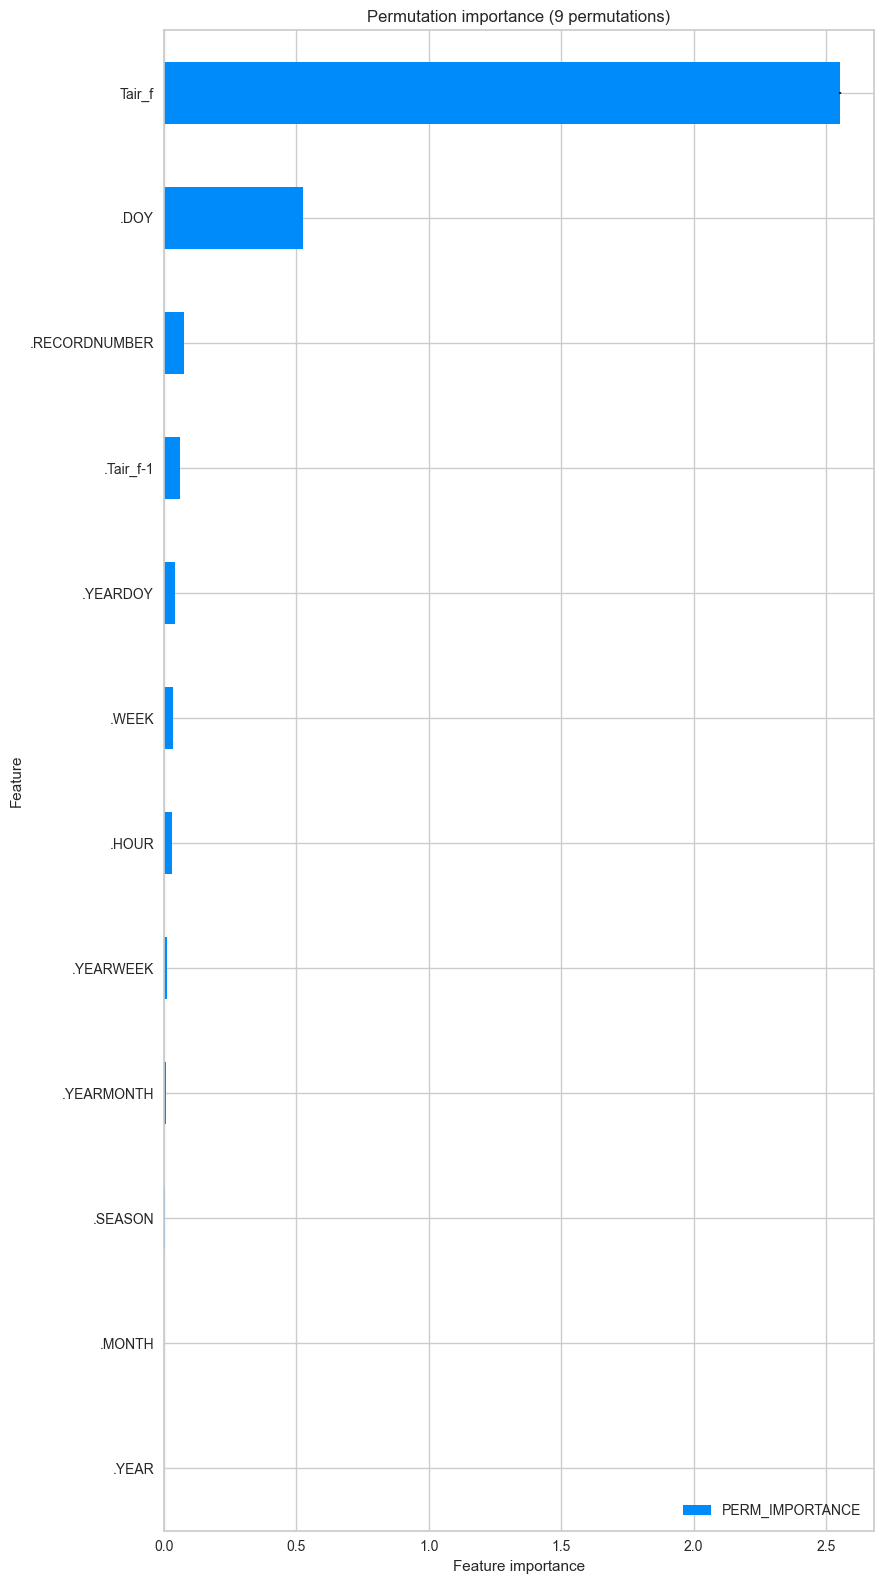

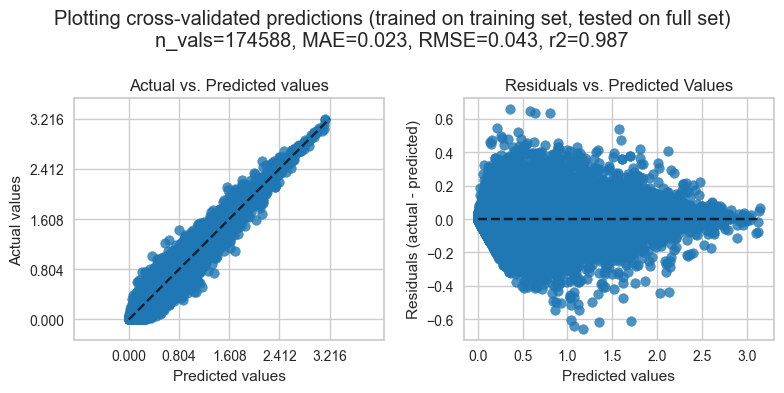


Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)


In [10]:
gfcols = [vpd_col, ta_col]
gf_df = subset_df[gfcols].copy()
rfts = QuickFillRFTS(df=gf_df, target_col=vpd_col)
rfts.fill()
subset_df[vpd_gf_col] = rfts.get_gapfilled_target()

In [11]:
subset_df

,Tair_f,RH,VPD_hPa,VPD_hPa_gfRF
TIMESTAMP_MIDDLE,,,,
2013-01-01 00:15:00,-1.618000,31.933333,0.369155,0.352673
2013-01-01 00:45:00,-1.630000,32.600000,0.365215,0.365215
2013-01-01 01:15:00,-1.644000,38.866667,0.330915,0.330915
2013-01-01 01:45:00,-1.657000,37.766667,0.336546,0.336546
2013-01-01 02:15:00,-0.567000,39.533333,0.354320,0.354320
...,...,...,...,...
2022-12-31 21:45:00,3.463333,71.790000,0.221004,0.221004
2022-12-31 22:15:00,5.283333,62.626667,0.332750,0.332750
2022-12-31 22:45:00,5.536667,61.746667,0.346650,0.346650


</br>

# **Plot some variables**

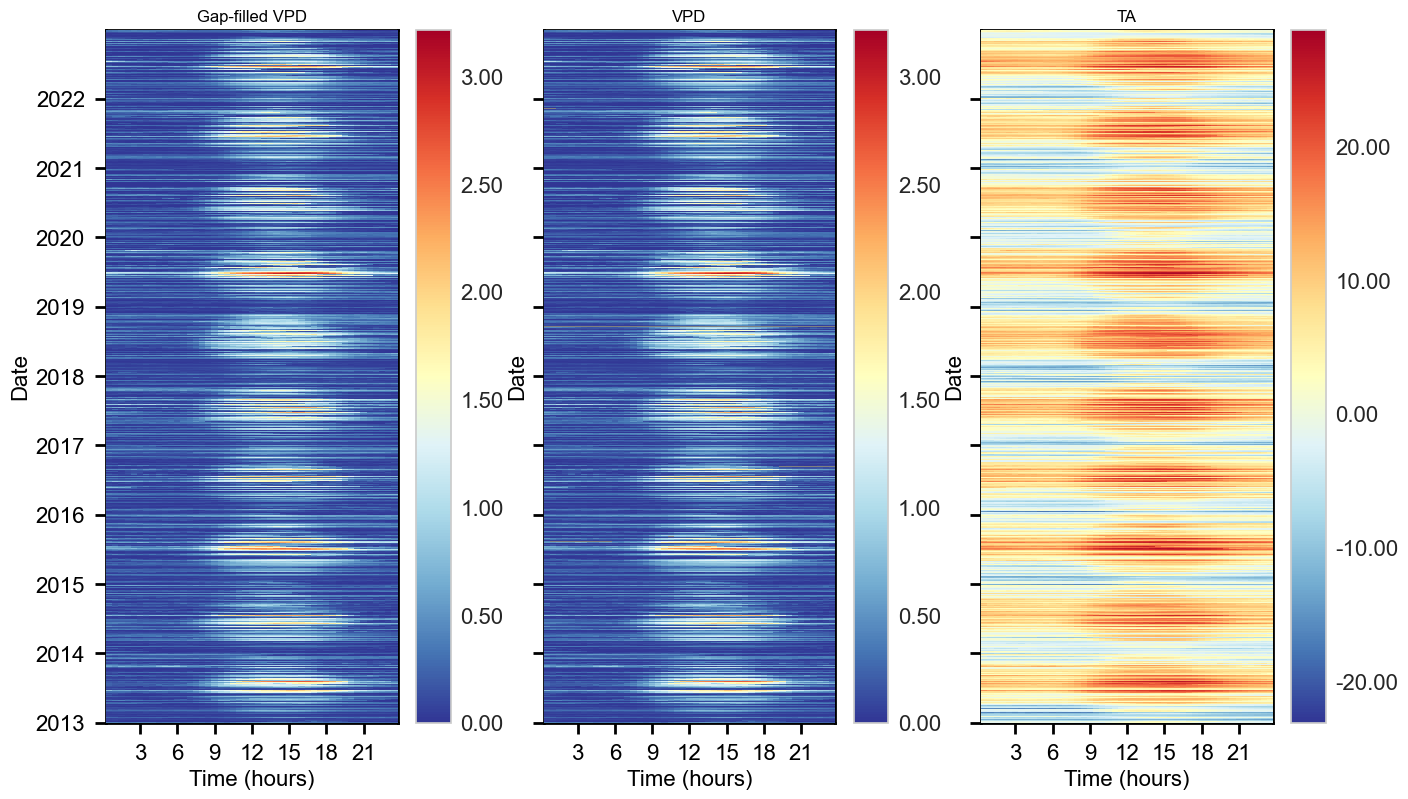

In [12]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
ax_fc = fig.add_subplot(gs[0, 0])
ax_le = fig.add_subplot(gs[0, 1])
ax_ta = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_fc, series=subset_df['VPD_hPa_gfRF']).plot()
HeatmapDateTime(ax=ax_le, series=subset_df['VPD_hPa']).plot()
HeatmapDateTime(ax=ax_ta, series=subset_df['Tair_f']).plot()
ax_fc.set_title("Gap-filled VPD", color='black')
ax_le.set_title("VPD", color='black')
ax_ta.set_title("TA", color='black')
ax_le.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_ta.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)

</br>

# **Insert TIMESTAMP_END**
- `diive` uses TIMESTAMP_MIDDLE for calculations, but sometimes TIMESTAMP_END is required for output files

In [13]:
subset_df = insert_timestamp(data=subset_df, convention='end')
subset_df

,TIMESTAMP_END,Tair_f,RH,VPD_hPa,VPD_hPa_gfRF
TIMESTAMP_MIDDLE,,,,,
2013-01-01 00:15:00,2013-01-01 00:30:00,-1.618000,31.933333,0.369155,0.352673
2013-01-01 00:45:00,2013-01-01 01:00:00,-1.630000,32.600000,0.365215,0.365215
2013-01-01 01:15:00,2013-01-01 01:30:00,-1.644000,38.866667,0.330915,0.330915
2013-01-01 01:45:00,2013-01-01 02:00:00,-1.657000,37.766667,0.336546,0.336546
2013-01-01 02:15:00,2013-01-01 02:30:00,-0.567000,39.533333,0.354320,0.354320
...,...,...,...,...,...
2022-12-31 21:45:00,2022-12-31 22:00:00,3.463333,71.790000,0.221004,0.221004
2022-12-31 22:15:00,2022-12-31 22:30:00,5.283333,62.626667,0.332750,0.332750
2022-12-31 22:45:00,2022-12-31 23:00:00,5.536667,61.746667,0.346650,0.346650


</br>

# **Plot**

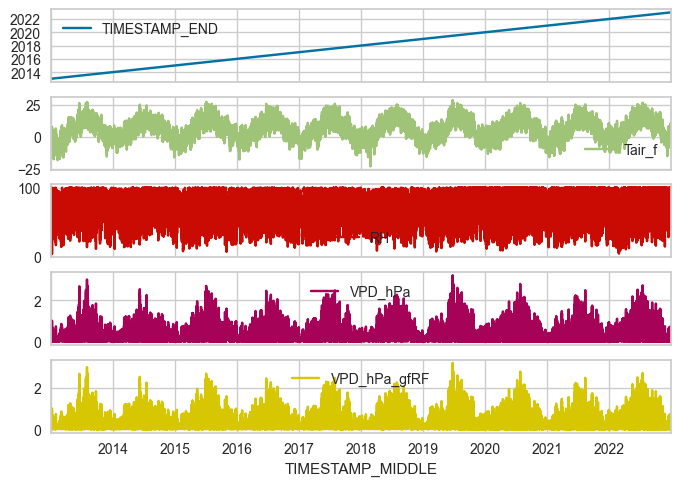

In [14]:
subset_df.plot(subplots=True)
plt.show()

</br>

# **Save to CSV file**

In [15]:
outfile = "vpd.csv"
subset_df.to_csv(outfile, index=False)

</br>

# **End of notebook**

In [16]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2023-10-31 11:20:49
